In [1]:
import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt

import json, calendar

from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
def get_data(y):
    url = 'https://github.com/users/chAwater/contributions?from=' + y + '-12-01&to=' + y + '-12-31'
    html  = urlopen(url)
    bsObj = BeautifulSoup(html,'lxml')
    table = bsObj.findAll('rect', {'class':'ContributionCalendar-day'})
    
    df = pd.DataFrame(
        [ rect.attrs for rect in table ]
    ).drop( ['class','height','width', 'rx', 'ry'], axis=1, errors='ignore' ).dropna(how='any').astype(
        {
            'x':int, 'y':int,
            'data-count':int
        }
    )

    df['x'] += -1*df.min()['x']

    df['date'] = pd.to_datetime(df['data-date'])

    df['month']   = df['date'].apply(lambda row: calendar.month_abbr[row.month])
    df['year']    = df['date'].apply(lambda row: row.year).apply(str)
    df['weekday'] = df['date'].apply(lambda row: row.day_name()[:3])

    df = df.query('year==@y')

    return df

In [3]:
def plot_df(df):
    y = str(df['year'].unique()[0])
    
    x_labels = df.loc[ df['month'].drop_duplicates().index , ['x','month']]
    y_labels = df[['y','weekday']].drop_duplicates().sort_values('y')[1::2]

#     c_labels = df.groupby('fill')['data-count'].max().sort_values().apply( lambda row: np.ceil(row/5).astype(int)*5 ).reset_index()
#     c_labels = df.groupby('fill')['data-count'].max().sort_values().reset_index()
#     c_labels['idx'] = c_labels.index.to_numpy()*5
    c_labels = sns.color_palette('Greens',5)

    fig, ax = plt.subplots(figsize=(15,2))
    cbar_ax = fig.add_axes([0.80, 0.0, 0.07, 0.1]) # [left, bottom, width, height]

#     ax.scatter( x=df['x'], y=df['y'], color=df['fill'], s=105, marker='s')
    ax.scatter( x=df['x'], y=df['y'], color=df['data-level'].apply(lambda x: c_labels[int(x)] if x!='0' else 'whitesmoke'), s=105, marker='s')

    ax.set_xticks(x_labels['x']-1)
    ax.set_xticklabels(x_labels['month'])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    ax.set_yticks(y_labels['y'])
    ax.set_yticklabels(y_labels['weekday'])

    ax.tick_params(length=0)

#     cbar_ax.scatter( x=c_labels.index.tolist(), y=[0]*c_labels.shape[0], color=c_labels['fill'], s=100, marker='s')
    cbar_ax.scatter( x=np.arange(0,5), y=[0]*5, color=c_labels, s=100, marker='s')
    cbar_ax.set_yticks([])
#     cbar_ax.set_xticks(c_labels.index.tolist())
    cbar_ax.set_xticks(np.arange(0,5))
#     cbar_ax.set_xticklabels(c_labels['idx'])
    cbar_ax.set_xticklabels(df.groupby('data-level')['data-count'].max().values)
    cbar_ax.tick_params(length=0)
    cbar_ax.set_xlim(-0.5,5.5)
    cbar_ax.tick_params(length=0)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_visible(False)
        cbar_ax.spines[axis].set_visible(False)

    x1,x2 = ax.get_xlim()
    y1,y2 = ax.get_ylim()

    ax.set_xlim( int(x2+2), int(x1-2) )
    ax.set_ylim( int(y2+8), int(y1-8) )

    ax.set_title('GitHub Contributions @ '+y)

    fig.savefig('GitHub_Contributions_' +str(y) + '.png', bbox_inches='tight')
    fig.savefig('GitHub_Contributions_' +str(y) + '.svg', bbox_inches='tight')

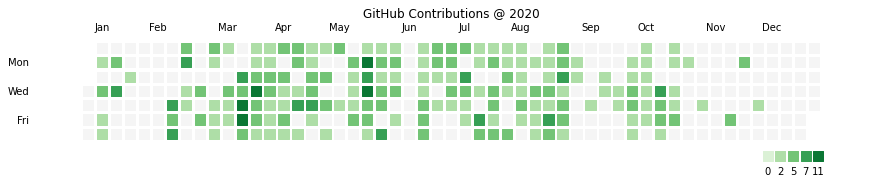

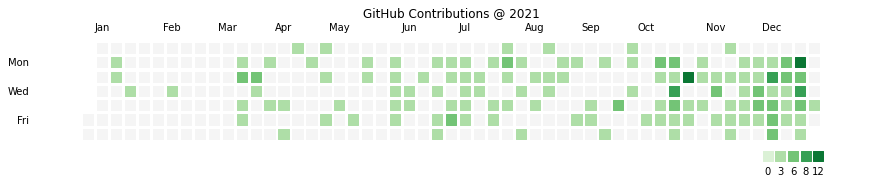

In [4]:
# for y in ['2018','2019']:
for y in ['2020','2021']:
    df = get_data(y)
    plot_df(df)
